In [1]:
%matplotlib inline
import bilby
import numpy as np
import matplotlib.pyplot as plt
from gwpy.timeseries import TimeSeries
from gwpy.signal.filter_design import bandpass, concatenate_zpks, notch
from gwpy.signal import filter_design
from gwpy.plot import Plot

/home/ethanmillar/gravwaves/lib/python3.10/site-packages/gwpy/time/__init__.py:36: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(True)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  from lal import LIGOTimeGPS


# Setting Universal Parameters

In [2]:
sampling_frequency = 4096
duration = 30
minimum_frequency = 20

merger_time = np.random.randint(1126051217, 1137254417-duration)

start_time = merger_time - (duration/2)
end_time = start_time + duration

# Setting Simulated Signal Parameters

In [3]:
injection_parameters = dict(
    mass_1=36., 
    mass_2=29.,
    a_1=0.4, 
    a_2=0.3, 
    tilt_1=0.5, 
    tilt_2=1.0, 
    phi_12=1.7, 
    phi_jl=0.3,
    luminosity_distance=500., 
    theta_jn=0.4, 
    psi=2.659,
    phase=1.3, 
    geocent_time=merger_time,
    ra=1.375, 
    dec=-1.2108
    )


waveform_arguments = dict(
    waveform_approximant="IMRPhenomPv2",
    reference_frequency=minimum_frequency,
    minimum_frequency=minimum_frequency,
    start_time=merger_time - 2
)

waveform_generator = bilby.gw.WaveformGenerator(
    duration = duration,
    sampling_frequency=sampling_frequency,
    frequency_domain_source_model=bilby.gw.source.lal_binary_black_hole,
    parameter_conversion=bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters,
    waveform_arguments=waveform_arguments,
)


16:27 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters


# Defining the Strain Data

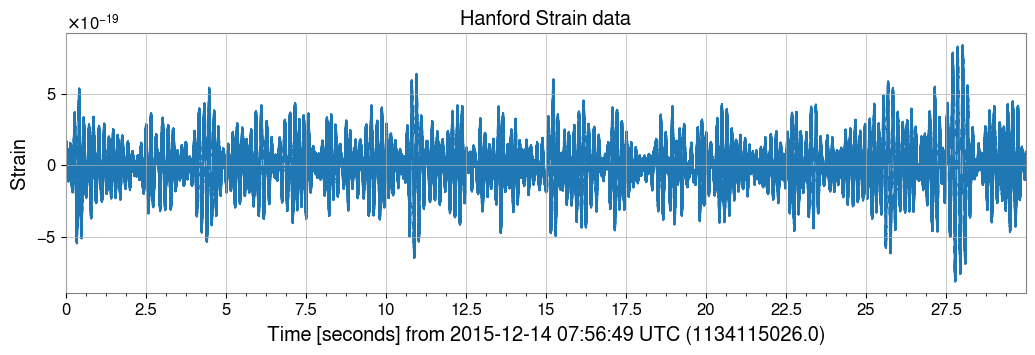

In [4]:
time_series = TimeSeries.fetch_open_data('H1', start_time, end_time) #Fetching the data from GWOSC

plot = time_series.plot()

ax = plot.gca()
ax.set_title('Hanford Strain data')
ax.set_ylabel('Strain')

plot = plt.show()

## Plotting the generated wave with no noise

Plotting the simualted waveform for troubleshooting, allows us to see what the waveform looks like in isolation

16:28 bilby INFO    : Injected signal in H1:
16:28 bilby INFO    :   optimal SNR = 33.99
16:28 bilby INFO    :   matched filter SNR = 33.99-0.00j
16:28 bilby INFO    :   mass_1 = 36.0
16:28 bilby INFO    :   mass_2 = 29.0
16:28 bilby INFO    :   a_1 = 0.4
16:28 bilby INFO    :   a_2 = 0.3
16:28 bilby INFO    :   tilt_1 = 0.5
16:28 bilby INFO    :   tilt_2 = 1.0
16:28 bilby INFO    :   phi_12 = 1.7
16:28 bilby INFO    :   phi_jl = 0.3
16:28 bilby INFO    :   luminosity_distance = 500.0
16:28 bilby INFO    :   theta_jn = 0.4
16:28 bilby INFO    :   psi = 2.659
16:28 bilby INFO    :   phase = 1.3
16:28 bilby INFO    :   geocent_time = 1134115041
16:28 bilby INFO    :   ra = 1.375
16:28 bilby INFO    :   dec = -1.2108


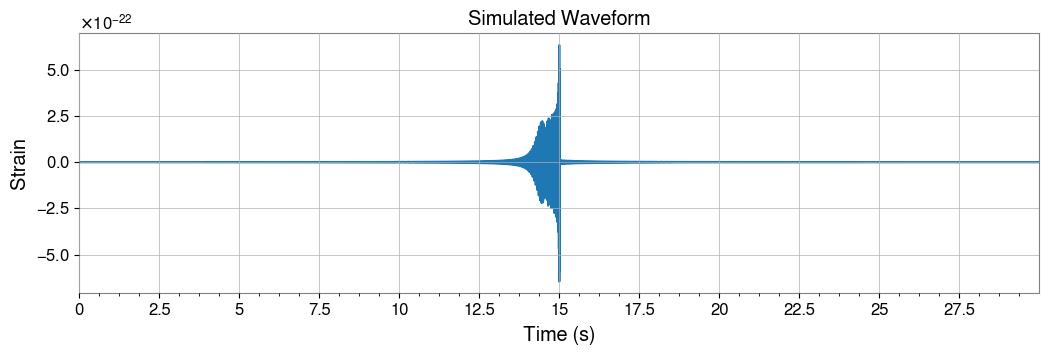

In [5]:
#Setting empty interferometer 
H1 = bilby.gw.detector.get_empty_interferometer('H1')

#Setting the strain data with zero noise
H1.set_strain_data_from_zero_noise(sampling_frequency=sampling_frequency, duration=duration, start_time = start_time)

#Injecting generated waveform into interferomoter
H1.inject_signal_from_waveform_generator(parameters=injection_parameters, waveform_generator=waveform_generator)

#Converting strain data into timeseries
timeseries_no_noise = TimeSeries(
            data=H1.strain_data.time_domain_strain, times=H1.strain_data.time_array)

#Plotting the simulated waveform

plot = timeseries_no_noise.plot()

ax = plot.gca()
ax.set_title('Simulated Waveform')
ax.set_ylabel('Strain')
plt.xlabel('Time (s)')

plot = plt.show()

# Injecting the signal into the GWOSC Strain

16:29 bilby INFO    : Injected signal in H1:
16:29 bilby INFO    :   optimal SNR = 33.99
16:29 bilby INFO    :   matched filter SNR = -10.19+8.71j
16:29 bilby INFO    :   mass_1 = 36.0
16:29 bilby INFO    :   mass_2 = 29.0
16:29 bilby INFO    :   a_1 = 0.4
16:29 bilby INFO    :   a_2 = 0.3
16:29 bilby INFO    :   tilt_1 = 0.5
16:29 bilby INFO    :   tilt_2 = 1.0
16:29 bilby INFO    :   phi_12 = 1.7
16:29 bilby INFO    :   phi_jl = 0.3
16:29 bilby INFO    :   luminosity_distance = 500.0
16:29 bilby INFO    :   theta_jn = 0.4
16:29 bilby INFO    :   psi = 2.659
16:29 bilby INFO    :   phase = 1.3
16:29 bilby INFO    :   geocent_time = 1134115041
16:29 bilby INFO    :   ra = 1.375
16:29 bilby INFO    :   dec = -1.2108


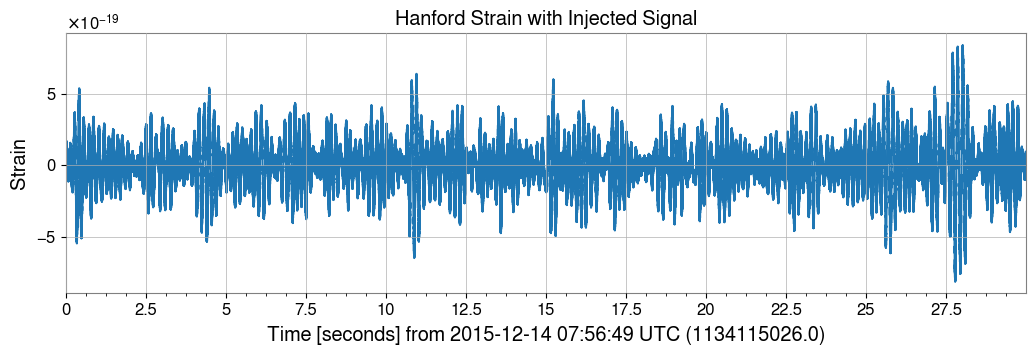

In [6]:
data_injected, metadata = bilby.gw.detector.inject_signal_into_gwpy_timeseries(data = time_series,
    waveform_generator=waveform_generator, parameters=injection_parameters, det = 'H1'
)

plot = data_injected.plot()

ax = plot.gca()
ax.set_ylabel('Strain')
ax.set_title('Hanford Strain with Injected Signal')

plt.show()

# Filtering the data

/home/ethanmillar/gravwaves/lib/python3.10/site-packages/gwpy/plot/plot.py:287: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  super().show(warn=warn)


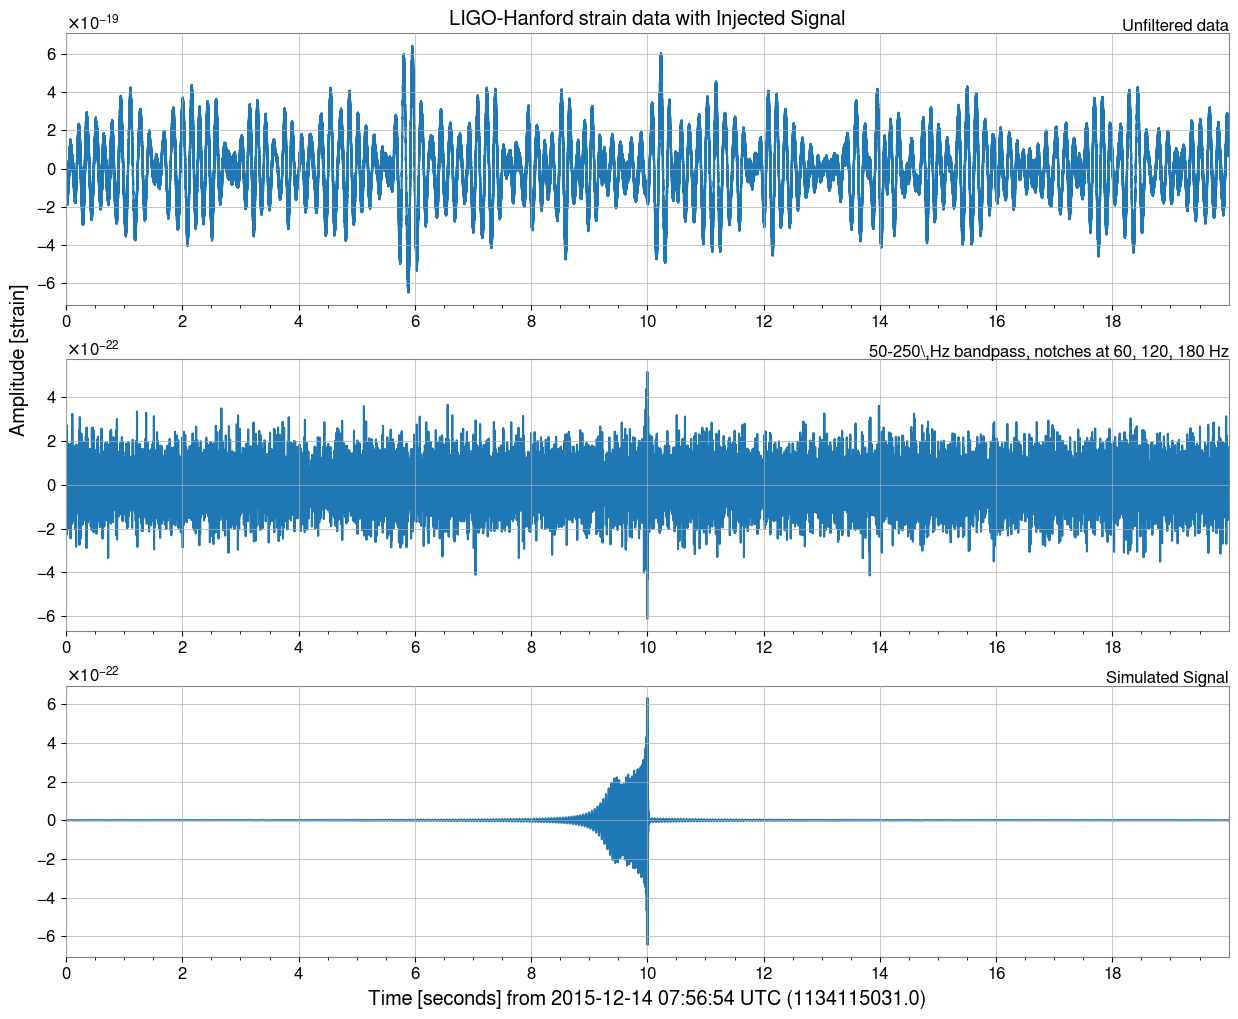

In [7]:
#Setting the bandpass filter to cut out high and low frequencies
bp = filter_design.bandpass(50, 250, time_series.sample_rate)

#Setting notch filters for the first 3 harmonics of 60Hz AC mains power supply
notches = [filter_design.notch(line, time_series.sample_rate) for
           line in (60, 120, 180)]

#Concatenate filters together
zpk = filter_design.concatenate_zpks(bp, *notches)

#Applying the filter
data_filtered = data_injected.filter(zpk, filtfilt=True)

#Cropping the data to remove corrupted data at the beginning and end of data (caused by filter) 
data_filtered_crop = data_filtered.crop(start_time+5,end_time-5)

#Cropping unfiltered data for comparison
data_injected_crop = data_injected.crop(start_time+5,end_time-5)
timeseries_no_noise_crop = timeseries_no_noise.crop(start_time+5,end_time-5)

plot = Plot(data_injected_crop, data_filtered_crop,timeseries_no_noise_crop, figsize = [15,12], separate=True, sharex=True)

ax1,ax2,ax3 = plot.axes

ax1.set_title('LIGO-Hanford strain data with Injected Signal')
ax1.text(1.0, 1.01, 'Unfiltered data', transform=ax1.transAxes, ha='right')
ax1.set_ylabel('Amplitude [strain]', y=-0.2)

ax2.set_ylabel('')
ax2.text(1.0, 1.01, r'50-250\,Hz bandpass, notches at 60, 120, 180 Hz',
         transform=ax2.transAxes, ha='right')

ax3.set_ylabel('')
ax3.text(1.0, 1.01, r'Simulated Signal',
         transform=ax3.transAxes, ha='right')


plot.show()

# Plotting Q-scan of the signal Data

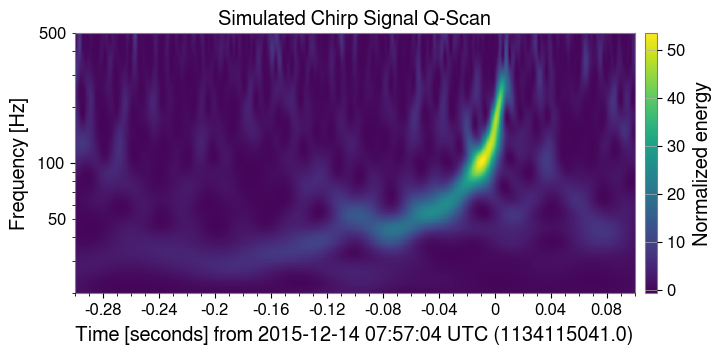

In [26]:
#Performing Q-transform of the injected data timeseries
#outseg selects the GPS segment where the Q scan is taken over
qspecgram = data_injected.q_transform(outseg=(merger_time - 0.3, merger_time+0.1))

plot = qspecgram.plot(figsize=[8, 4])
ax = plot.gca()

ax.set_title('Simulated Chirp Signal Q-Scan')
ax.set_xscale('seconds')
ax.set_yscale('log')
ax.set_ylim(20, 500)
ax.set_xlim(merger_time-0.3, merger_time + 0.1)
ax.set_ylabel('Frequency [Hz]')
ax.grid(False)
ax.colorbar(cmap='viridis', label='Normalized energy')
#plt.savefig('Q_scan.jpeg')
plot.show()t